In [ ]:
import pandas as pd
import numpy as np
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = [0, 1]

: 

In [24]:
df = pd.read_csv("/content/SupervisedFraudData (1).csv")
df.head()

,Time_step,Transaction_Id,Sender_Id,Sender_Account,Sender_Country,Sender_Sector,Sender_lob,Bene_Id,Bene_Account,Bene_Country,USD_amount,Label,Transaction_Type
0,2022-03-15 10:24:00,EXCHANGE-10115,Unknown,Unknown,Unknown,0,Unknown,Unknown,Unknown,Unknown,558.43,0,WITHDRAWAL
1,2022-03-15 10:24:00,QUICK-PAYMENT-10116,Unknown,Unknown,Unknown,0,Unknown,Unknown,Unknown,Unknown,622.78,0,QUICK-PAYMENT
2,2022-03-15 10:24:00,DEPOSIT-CASH-9833,Unknown,Unknown,Unknown,0,Unknown,Unknown,Unknown,Unknown,802.54,0,DEPOSIT-CASH
3,2022-03-15 10:24:00,PAY-CHECK-9832,Unknown,Unknown,Unknown,0,Unknown,Unknown,Unknown,Unknown,989.09,0,PAY-CHECK
4,2022-03-15 10:24:00,DEPOSIT-CHECK-9806,Unknown,Unknown,Unknown,0,Unknown,Unknown,Unknown,Unknown,786.78,0,DEPOSIT-CHECK


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1498177 entries, 0 to 1498176
Data columns (total 13 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   Time_step         1498177 non-null  object 
 1   Transaction_Id    1498177 non-null  object 
 2   Sender_Id         1498177 non-null  object 
 3   Sender_Account    1498177 non-null  object 
 4   Sender_Country    1498177 non-null  object 
 5   Sender_Sector     1498177 non-null  int64  
 6   Sender_lob        1498177 non-null  object 
 7   Bene_Id           1498177 non-null  object 
 8   Bene_Account      1498177 non-null  object 
 9   Bene_Country      1498177 non-null  object 
 10  USD_amount        1498177 non-null  float64
 11  Label             1498177 non-null  int64  
 12  Transaction_Type  1498177 non-null  object 
dtypes: float64(1), int64(2), object(10)
memory usage: 148.6+ MB


In [26]:
df.describe()

,Sender_Sector,USD_amount,Label
count,1498177.0,1.498177e+06,1.498177e+06
mean,0.0,5.134698e+02,2.057100e-02
std,0.0,5.398089e+02,1.419431e-01
min,0.0,0.000000e+00,0.000000e+00
25%,0.0,1.386900e+02,0.000000e+00
50%,0.0,4.041600e+02,0.000000e+00
75%,0.0,7.340700e+02,0.000000e+00
max,0.0,1.999894e+04,1.000000e+00


Text(0, 0.5, 'Frequency')

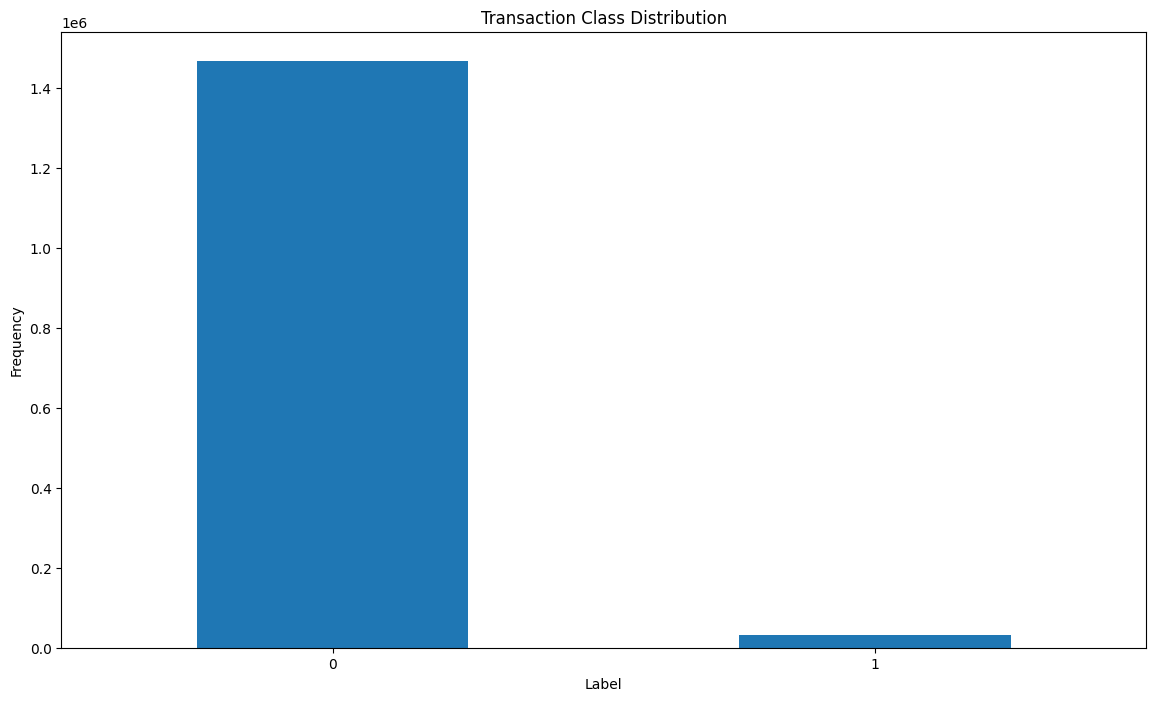

In [27]:
count_classes = pd.value_counts(df['Label'], sort = True)

count_classes.plot(kind = 'bar', rot=0)

plt.title("Transaction Class Distribution")

plt.xticks(range(2), LABELS)

plt.xlabel("Label")

plt.ylabel("Frequency")

In [28]:
fraud = df[df['Label'] == 1]
normal = df[df['Label'] == 0]

In [29]:
print(fraud.shape,normal.shape)

(30819, 13) (1467358, 13)


In [30]:
fraud.USD_amount.describe()

count    30819.000000
mean       847.442043
std       2003.566402
min        100.000000
25%        254.115000
50%        512.230000
75%        773.975000
max      19998.940000
Name: USD_amount, dtype: float64

In [31]:
normal.USD_amount.describe()

count    1.467358e+06
mean     5.064553e+02
std      4.591433e+02
min      0.000000e+00
25%      1.355300e+02
50%      4.011900e+02
75%      7.330300e+02
max      1.985449e+04
Name: USD_amount, dtype: float64

In [32]:
len(fraud)/len(normal)

0.02100305446932514

In [35]:
df1= df.sample(frac = 0.2,random_state=1)
df1.shape

(299635, 13)

In [36]:
Fraud = df1[df1['Label']==1]

Valid = df1[df1['Label']==0]

outlier_fraction = len(Fraud)/float(len(Valid))

In [37]:
print(outlier_fraction)

print("Fraud Cases : {}".format(len(Fraud)))

print("Valid Cases : {}".format(len(Valid)))

0.021007257982076533
Fraud Cases : 6165
Valid Cases : 293470


In [56]:
df1['Time_step'].apply(lambda x:x.toordinal())
df1["Time_step"]

TypeError: <lambda>() got an unexpected keyword argument 'inPlace'

In [46]:
columns_to_drop = ['Label']

# Drop the specified column(s)
X = df1.drop(columns=columns_to_drop)
Y = df1["Label"]
state = np.random.RandomState(42)
X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))
print(X.shape)
print(Y.shape)

(299635, 12)
(299635,)


In [47]:
classifiers = {
    "Isolation Forest":IsolationForest(n_estimators=100, max_samples=len(X),
                                       contamination=outlier_fraction,random_state=state, verbose=0),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto',
                                              leaf_size=30, metric='minkowski',
                                              p=2, metric_params=None, contamination=outlier_fraction),
    "Support Vector Machine":OneClassSVM(kernel='rbf', degree=3, gamma=0.1,nu=0.05,
                                         max_iter=-1)

}

In [48]:
type(classifiers)

dict

In [54]:
n_outliers = len(Fraud)
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_prediction = clf.negative_outlier_factor_
    elif clf_name == "Support Vector Machine":
        clf.fit(X)
        y_pred = clf.predict(X)
    else:
        clf.fit(X)
        scores_prediction = clf.decision_function(X)
        y_pred = clf.predict(X)
    #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != Y).sum()
    # Run Classification Metrics
    print("{}: {}".format(clf_name,n_errors))
    print("Accuracy Score :")
    print(accuracy_score(Y,y_pred))
    print("Classification Report :")
    print(classification_report(Y,y_pred))

DTypePromotionError: The DType <class 'numpy.dtypes.Int64DType'> could not be promoted by <class 'numpy.dtypes.DateTime64DType'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtypes.DateTime64DType'>, <class 'numpy.dtypes.ObjectDType'>, <class 'numpy.dtypes.ObjectDType'>, <class 'numpy.dtypes.ObjectDType'>, <class 'numpy.dtypes.ObjectDType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.ObjectDType'>, <class 'numpy.dtypes.ObjectDType'>, <class 'numpy.dtypes.ObjectDType'>, <class 'numpy.dtypes.ObjectDType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.ObjectDType'>)